In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import datagen
from utils import datatreat
from utils import tau_GD
from utils import solve_ridge
from utils import eigen_val
from utils import PGD
from utils import FWGD

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,128)
mu,L=eigen_val(A,0)

Number of obs: 173
n train: 128
n test: 45
Number of explicative variables: 9


In [4]:
def mse(x): return 0.5*np.linalg.norm(A@x-y)**2/n_train

def dmse(x): return A.T@(A@x-y)/n_train

In [5]:
def dmse_ridge(x,lbd): return A.T@(A@x-y)/n_train+lbd*x
def mse_elastic_net(x,lbd,mu): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2+mu*np.linalg.norm(x,1)

def ISTA(tau,lbd,mu,x_0,n_iter):
    
    x=np.zeros((n_iter,x_0.size))
    x[0]=x_0
    
    fx=np.full(n_iter,mse_elastic_net(x[0],lbd,mu))
    tau=tau*np.ones(n_iter)
    
    for i in range(1,n_iter):
        
        grad_ridge=dmse_ridge(x[i-1],lbd)
        iter_GD=x[i-1]-tau[i]*grad_ridge
        
        ind_left=np.argwhere(iter_GD<-tau[i]*mu)
        ind_right=np.argwhere(iter_GD> tau[i]*mu)

        x[i,ind_left]= iter_GD[ind_left]+tau[i]*mu
        x[i,ind_right]= iter_GD[ind_right]-tau[i]*mu

        fx[i]=mse_elastic_net(x[i],lbd,mu)
        
    return x,fx

In [6]:
x,trash=solve_ridge(A,y,0)
R_L2_star=np.linalg.norm(x)
R_L2=5.25
print(R_L2_star,R_L2)

5.429668585968503 5.25


In [7]:
x_0=np.ones(p)
n_iter=100
tau_max,tau_opt=tau_GD(A,0)

In [8]:
'''
x_star_L2,trash=solve_ridge(A,y,0.0292125258648815)
print(np.linalg.norm(x_star_L2))
fx_star_L2=mse(x_star_L2)
print(fx_star_L2)
'''

x,trash=ISTA(tau_opt,0.0292125258648815,0,x_0,2000)
print(np.linalg.norm(x[-1]))
print(mse(x[-1]))
x_star_L2=x[-1]
fx_star_L2=mse(x_star_L2)

5.250000000000017
2.412218672742907


In [9]:
def proj_L2(x,R): return R*x/(np.maximum(np.linalg.norm(x),R))

def iter_FW_L2(x,R): return -R*dmse(x)/np.linalg.norm(dmse(x))

def theta_FW_fix(x,s,k): return 2/(k+1)

def theta_FW_opt(x,s,k): 
    N=np.linalg.norm(A@(s-x))**2
    D=np.dot(A@(s-x),A@x-y)
    C=-D/N
    if(C<0): return 0
    elif(C>1): return 1
    else: return C   

In [10]:
xPGD,fxPGD=PGD(lambda x: proj_L2(x,R_L2), tau_opt, x_0, mse, dmse, n_iter)
errPGD=np.linalg.norm(xPGD-x_star_L2,axis=1)
errfPGD=fxPGD-fx_star_L2
print(np.max(np.linalg.norm(xPGD,axis=1)))
print(fxPGD[-1])
print("-"*50)

xFWGD_fix,fxFWGD_fix=FWGD(lambda x: iter_FW_L2(x,R_L2),theta_FW_fix, x_0, mse, dmse, n_iter)
errFWGD_fix=np.linalg.norm(xFWGD_fix-x_star_L2,axis=1)
errfFWGD_fix=fxFWGD_fix-fx_star_L2
print(np.max(np.linalg.norm(xFWGD_fix,axis=1)))
print(fxFWGD_fix[-1])
print("-"*50)

xFWGD_opt,fxFWGD_opt=FWGD(lambda x: iter_FW_L2(x,R_L2),theta_FW_opt, x_0, mse, dmse, n_iter)
errFWGD_opt=np.linalg.norm(xFWGD_opt-x_star_L2,axis=1)
errfFWGD_opt=fxFWGD_opt-fx_star_L2
print(np.max(np.linalg.norm(xFWGD_opt,axis=1)))
print(fxFWGD_opt[-1])

#FW_upperbound_L2=rho=2*L*4*R_L2**2/np.arange(2,n_iter+2)

5.250000000000001
2.412219475445704
--------------------------------------------------
5.249999999999999
2.415185582434112
--------------------------------------------------
5.25
2.41221867472749


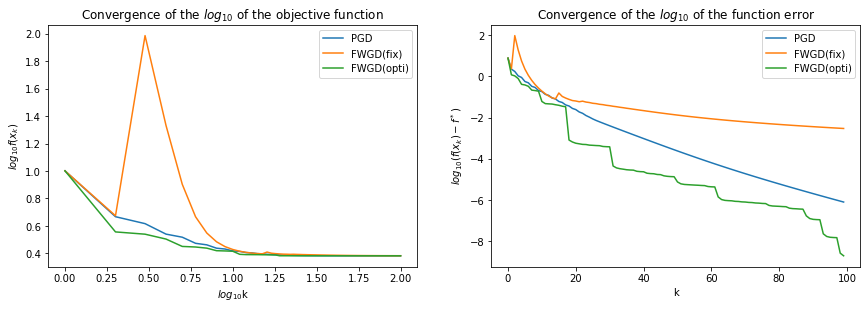

In [11]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxPGD),label='PGD')
ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxFWGD_fix),label='FWGD(fix)')
ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxFWGD_opt),label='FWGD(opti)')
ax0.set_xlabel('$log_{10}$k')
ax0.set_ylabel('$log_{10}f(x_k)$')
ax0.set_title('Convergence of the $log_{10}$ of the objective function')
ax0.legend()

ax1.plot(np.log10(errfPGD),label='PGD')
ax1.plot(np.log10(errfFWGD_fix),label='FWGD(fix)')
ax1.plot(np.log10(errfFWGD_opt),label='FWGD(opti)')
ax1.set_xlabel('k')
ax1.set_ylabel('$log_{10}(f(x_k)-f^*)$')
ax1.set_title('Convergence of the $log_{10}$ of the function error ')
ax1.legend()


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=0.2, hspace=None)

In [12]:
x,trash=solve_ridge(A,y,0)
R_L1_star=np.linalg.norm(x,1)
R_L1=np.floor(R_L1_star)
print(R_L1_star,R_L1)

14.483338245059231 14.0


In [13]:
x,trash=ISTA(tau_opt,0,0.204557386591880,x_0,2000)
print(np.linalg.norm(x[-1],1))
print(mse(x[-1]))
x_star_L1=x[-1]
fx_star_L1=mse(x_star_L1)

14.000000000000004
2.448790065633061


In [14]:
def proj_simplex(x,R):
    u=np.flip(np.sort(x))
    K=0
    while( (( (np.sum(u[:K+1])-R)/(K+1)) < u[K]) ): 
        K=K+1
        if(K==x.size-1): break
            
    tau=(np.sum(u[:K+1])-R)/(K+1)
    return np.maximum(x-tau,0)

def proj_L1(x,R): 
    if(np.linalg.norm(x,1)<=R): return x
    else: return np.sign(x)*proj_simplex(x,R)
        

def iter_FW_L1(x,R):
    k_star=np.argmax(np.abs(dmse(x)))
    s=np.zeros(x.size)
    s[k_star]=-R*np.sign(dmse(x)[k_star])
    return s

In [15]:
n_iter=200
xPGD,fxPGD=PGD(lambda x: proj_L1(x,R_L1), tau_opt, x_0, mse, dmse, n_iter)
errPGD=np.linalg.norm(xPGD-x_star_L1,axis=1)
errfPGD=fxPGD-fx_star_L1
print(np.max(np.linalg.norm(xPGD,1,axis=1)))
print(fxPGD[-1])
print("-"*50)

xFWGD_fix,fxFWGD_fix=FWGD(lambda x: iter_FW_L1(x,R_L1),theta_FW_fix, x_0, mse, dmse, n_iter)
errFWGD_fix=np.linalg.norm(xFWGD_fix-x_star_L1,axis=1)
errfFWGD_fix=fxFWGD_fix-fx_star_L1
print(np.max(np.linalg.norm(xFWGD_fix,1,axis=1)))
print(fxFWGD_fix[-1])
print("-"*50)

xFWGD_opt,fxFWGD_opt=FWGD(lambda x: iter_FW_L1(x,R_L1),theta_FW_opt, x_0, mse, dmse, n_iter)
errFWGD_opt=np.linalg.norm(xFWGD_opt-x_star_L1,axis=1)
errfFWGD_opt=fxFWGD_opt-fx_star_L1
print(np.max(np.linalg.norm(xFWGD_opt,1,axis=1)))
print(fxFWGD_opt[-1])

#FW_upperbound_L1=rho=2*L*9*R_L1**2/np.arange(2,n_iter+2)

14.000000000000004
2.448790153147365
--------------------------------------------------
14.0
2.45505399070725
--------------------------------------------------
13.611947270229187
2.5603952885808123


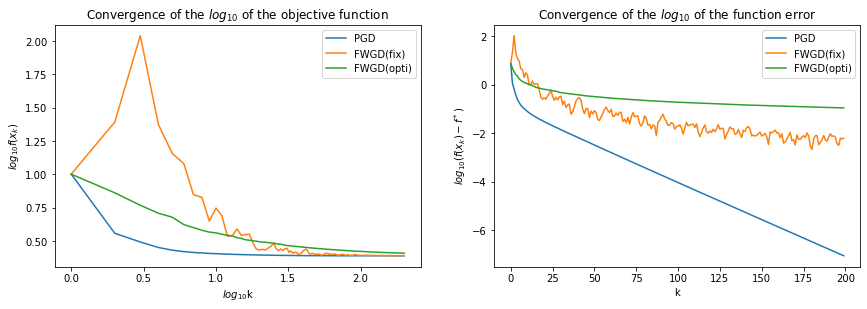

In [16]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxPGD),label='PGD')
ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxFWGD_fix),label='FWGD(fix)')
ax0.plot(np.log10(np.arange(1,n_iter+1)),np.log10(fxFWGD_opt),label='FWGD(opti)')
ax0.set_xlabel('$log_{10}$k')
ax0.set_ylabel('$log_{10}f(x_k)$')
ax0.set_title('Convergence of the $log_{10}$ of the objective function')
ax0.legend()

ax1.plot(np.log10(errfPGD),label='PGD')
ax1.plot(np.log10(errfFWGD_fix),label='FWGD(fix)')
ax1.plot(np.log10(errfFWGD_opt),label='FWGD(opti)')
ax1.set_xlabel('k')
ax1.set_ylabel('$log_{10}(f(x_k)-f^*)$')
ax1.set_title('Convergence of the $log_{10}$ of the function error ')
ax1.legend()


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=0.2, hspace=None)